# <center>Application of Ant Colony Optimization in FSP problem</center>

This notebook presents a practical approach to solving the flowshop problem by implementing the Ant Colony Optimization algorithm. These metaheuristics are effective in generating high-quality solutions for large instances of the problem, requiring only a reasonable amount of computational resources. Compared to heuristics, such metaheuristics are more effective for solving the flowshop problem because they can escape from local optima and find better solutions




## Data utils

In [1]:
import numpy as np
import random
import time
import math
import pandas as pd
import matplotlib.pyplot as plt

from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

from utils.benchmarks import benchmarks, upper_bound
from utils.heuristics import *
from utils.utils import read_flow_shop_data

### Path Cost calculation function :
Used to calculate the cost of current node, which is the correct cost starting for the actual path of executed jobs

In [2]:
def calculate_makespan(processing_times, sequence):
    n_jobs = len(sequence)
    n_machines = len(processing_times[0])
    end_time = [[0] * (n_machines + 1) for _ in range(n_jobs + 1)]

    for j in range(1, n_jobs + 1):
        for m in range(1, n_machines + 1):
            end_time[j][m] = max(end_time[j][m - 1], end_time[j - 1]
                                 [m]) + processing_times[sequence[j - 1]][m - 1]

    return end_time[n_jobs][n_machines]

### Gantt graph generator

In [3]:
def generate_gantt_chart(processing_times, seq, interval=50, labeled=True):
    data = processing_times.T
    nb_jobs, nb_machines = processing_times.shape
    schedules = np.zeros((nb_machines, nb_jobs), dtype=dict)
    # schedule first job alone first
    task = {"name": "job_{}".format(
        seq[0]+1), "start_time": 0, "end_time": data[0][seq[0]]}

    schedules[0][0] = task
    for m_id in range(1, nb_machines):
        start_t = schedules[m_id-1][0]["end_time"]
        end_t = start_t + data[m_id][0]
        task = {"name": "job_{}".format(
            seq[0]+1), "start_time": start_t, "end_time": end_t}
        schedules[m_id][0] = task

    for index, job_id in enumerate(seq[1::]):
        start_t = schedules[0][index]["end_time"]
        end_t = start_t + data[0][job_id]
        task = {"name": "job_{}".format(
            job_id+1), "start_time": start_t, "end_time": end_t}
        schedules[0][index+1] = task
        for m_id in range(1, nb_machines):
            start_t = max(schedules[m_id][index]["end_time"],
                          schedules[m_id-1][index+1]["end_time"])
            end_t = start_t + data[m_id][job_id]
            task = {"name": "job_{}".format(
                job_id+1), "start_time": start_t, "end_time": end_t}
            schedules[m_id][index+1] = task

    # create a new figure
    fig, ax = plt.subplots(figsize=(18, 8))

    # set y-axis ticks and labels
    y_ticks = list(range(len(schedules)))
    y_labels = [f'Machine {i+1}' for i in y_ticks]
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels)

    # calculate the total time
    total_time = max([job['end_time'] for proc in schedules for job in proc])

    # set x-axis limits and ticks
    ax.set_xlim(0, total_time)
    x_ticks = list(range(0, total_time+1, interval))
    ax.set_xticks(x_ticks)

    # set grid lines
    ax.grid(True, axis='x', linestyle='--')

    # create a color dictionary to map each job to a color
    color_dict = {}
    for proc in schedules:
        for job in proc:
            if job['name'] not in color_dict:
                color_dict[job['name']] = (np.random.uniform(
                    0, 1), np.random.uniform(0, 1), np.random.uniform(0, 1))

    # plot the bars for each job on each processor
    for i, proc in enumerate(schedules):
        for job in proc:
            start = job['start_time']
            end = job['end_time']
            duration = end - start
            color = color_dict[job['name']]
            ax.barh(i, duration, left=start, height=0.5,
                    align='center', color=color, alpha=0.8)
            if labeled:
                # add job labels
                label_x = start + duration/2
                label_y = i
                ax.text(
                    label_x, label_y, job['name'][4:], ha='center', va='center', fontsize=10)

    plt.show()

# Genetic Algorithm 

### L'opérateur de selection
- Sélectionner certaines solutions pour former la population intermédiaire afin de lui appliquer les opérateurs de croisement et de mutation.

In [14]:
def selection_AG(population, processing_times, n_selected, strategie):
    """
    Sélectionne une sous-population en fonction de la stratégie spécifiée.

    Args:
        population (list): La population actuelle de chromosomes (solutions).
        processing_times (array): Matrice des temps de traitement par machine et par job.
        n_selected (int): Nombre d'individus à sélectionner.
        strategie (str): Stratégie de sélection ('roulette', 'Elitism', 'rank', 'tournament').

    Returns:
        list: La sous-population sélectionnée selon la stratégie.
    """

    # Sélection par roulette:
    if strategie == "roulette":
        # Calcul de la fitness pour chaque individu dans la population
        fitness = [calculate_makespan(processing_times, sequence) for sequence in population]
        # Somme des valeurs de fitness pour normalisation
        fitness_sum = sum(fitness)
        # Calcul des probabilités de sélection proportionnelles à la fitness
        selection_probs = [fitness[i] / fitness_sum for i in range(len(population))]
        # Cumul des probabilités pour faciliter la sélection aléatoire
        cum_probs = [sum(selection_probs[:i+1]) for i in range(len(population))]
        selected = []

        # Sélection de n individus en fonction des probabilités cumulées
        for i in range(n_selected):
            while True:
                rand = random.random()
                for j, cum_prob in enumerate(cum_probs):
                    if rand < cum_prob:
                        break
                # Assure que chaque individu sélectionné est unique
                if population[j] not in selected:
                    selected.append(population[j])
                    break

    # Sélection par élitisme:
    elif strategie == "Elitism":
        # Évaluation de la fitness pour toute la population
        fitness = [calculate_makespan(processing_times, sequence) for sequence in population]
        # Tri de la population basé sur la fitness
        sorted_population = [x for x, _ in sorted(zip(population, fitness), key=lambda pair: pair[1])]
        # Sélection des meilleurs individus
        selected = sorted_population[:n_selected]

    # Sélection par classement:
    elif strategie == "rank":
        # Évaluation de la fitness pour toute la population
        fitness = [calculate_makespan(processing_times, sequence) for sequence in population]
        # Tri de la population par fitness
        sorted_population = sorted(population, key=lambda x: fitness[population.index(x)])
        # Calcul des poids pour la sélection aléatoire
        fitness_sum = sum(i + 1 for i in range(len(sorted_population)))
        selection_probs = [(len(sorted_population) - i) / fitness_sum for i in range(len(sorted_population))]
        selected = []

        # Sélection de n individus en fonction des poids
        for i in range(n_selected):
            selected_index = random.choices(range(len(sorted_population)), weights=selection_probs)[0]
            selected.append(sorted_population[selected_index])
            # Suppression pour éviter duplication dans les choix
            sorted_population.pop(selected_index)
            selection_probs.pop(selected_index)

    # Sélection par tournoi:
    elif strategie == "tournament":
        k = 2  # Taille du tournoi
        selected = []

        # Répéter jusqu'à ce que n individus soient sélectionnés
        for i in range(n_selected):
            while True:
                # Choix aléatoire de k individus
                tournament = random.sample(population, k)
                # Filtrer les individus déjà sélectionnés
                tournament = [seq for seq in tournament if seq not in selected]
                if tournament:
                    break
            # Évaluation de la fitness des individus du tournoi
            fitness = [calculate_makespan(processing_times, sequence) for sequence in tournament]
            # Sélection de l'individu avec la meilleure fitness
            selected.append(tournament[fitness.index(min(fitness))])

    return selected


### L'opérateur de croisement ( Crossover )
- Son principe est de prendre deux individus aléatoirement et de couper chacun d’eux en un ou plusieurs points, ensuite, inter changer les gènes situés entres les points considérés.

In [35]:
def remove_duplicates_AG(enfant, other_enfant, points):
    # Calcul de la taille de la liste des jobs, moins un pour obtenir l'indice maximum utilisable.
    jobs = len(enfant) - 1

    # Détermine si les points de crossover fournis sont multiples (typiquement pour un crossover à deux points).
    check_points = len(points) > 1

    # Boucle continue jusqu'à ce que tous les duplicats soient résolus.
    while True:
        # Crée un ensemble de jobs qui apparaissent plus d'une fois dans l'offspring.
        duplicates = set([job for job in enfant if enfant.count(job) > 1])

        # Si aucun duplicat n'est trouvé, sortir de la boucle.
        if not duplicates:
            break

        # Traiter chaque job dupliqué trouvé.
        for job in duplicates:
            # Trouve toutes les positions de ce job dans l'offspring.
            pos = [i for i, x in enumerate(enfant) if x == job]

            # Détermine quelle position du job dupliqué doit être corrigée.
            # Si des points de crossover sont spécifiés et que la première occurrence du job dupliqué est hors de ces points,
            # ou si aucun point n'est spécifié et que la première occurrence est avant le premier point,
            # alors 'dup' est la première position, sinon c'est la seconde.
            if (check_points and ((pos[0] < points[0]) or (pos[0] >= points[1])) ) or ( (pos[0] < points[0]) and not check_points):
                dup = pos[0]
                index = pos[1]
            else:
                dup = pos[1]
                index = pos[0]

            # Remplace le job dupliqué à la position 'dup' par un job de 'other_offspring' à la position 'index'.
            # Cette substitution est faite pour corriger la duplication tout en essayant de préserver la structure génétique du parent non-dupliqué.
            enfant[dup] = other_enfant[index]

    # Retourne l'offspring corrigé.
    return enfant


In [37]:
def crossover_AG(parent1, parent2, points):
    # Calcul de l'indice maximal utilisable pour le point de crossover, basé sur la longueur du parent.
    jobs = len(parent1) - 1

    # Si le mode de crossover est à un seul point ("ONE").
    if points == 'ONE':
        # Choix aléatoire d'un point de crossover dans la plage valide.
        point = random.randint(0, jobs)
        # Création de deux enfants en combinant les segments des deux parents autour du point de crossover.
        enfant1 = parent1[:point] + parent2[point:]
        enfant2 = parent2[:point] + parent1[point:]
        # Mise à jour des points pour la suppression des doublons.
        points = [point]

    else:  # Si le mode de crossover est à deux points.
        # Choix aléatoire de deux points de crossover.
        point_1 = random.randint(0, jobs)
        point_2 = random.randint(0, jobs)
        # Assurer que point_1 est inférieur à point_2.
        if point_1 > point_2:
            point_1, point_2 = point_2, point_1
        # Création des enfants en échangeant les segments entre les deux points choisis.
        enfant1 = parent1[:point_1] + parent2[point_1:point_2] + parent1[point_2:]
        enfant2 = parent2[:point_1] + parent1[point_1:point_2] + parent2[point_2:]
        # Mise à jour des points pour la suppression des doublons.
        points = [point_1, point_2]

    # Appel de la fonction pour retirer les doublons, en passant les enfants créés et les points de crossover.
    enfant1 = remove_duplicates_AG(enfant1, enfant2, points)
    enfant2 = remove_duplicates_AG(enfant2, enfant1, points)

    # Retourne les deux enfants après élimination des duplications.
    return enfant1, enfant2


### L'opérateur de mutation 
- Il consiste à choisir un ou deux bits aléatoirement, puis les inverser. L'opérateur de mutation s'applique avec une certaine probabilité Pm,
- Aide à maintenir et à introduire de la diversité génétique dans la population, ce qui peut empêcher l'algorithme de converger prématurément vers des optima locaux. 

In [48]:
def mutation_AG(sequence, mutation_rate):
    # Calcul de la longueur de la séquence, correspondant au nombre de jobs ou tâches
    num_jobs = len(sequence)
    
    # Parcours de chaque élément de la séquence pour potentiellement le muter
    for i in range(num_jobs):
        # Génération d'un nombre aléatoire entre 0 et 1
        r = random.random()
        
        # Vérification si ce nombre est inférieur au taux de mutation
        if r < mutation_rate:
            # Création d'une liste des indices de tous les jobs sauf celui à l'index i pour éviter de muter un job avec lui-même
            available_jobs = [j for j in range(num_jobs) if j != sequence[i]]
            
            # Sélection aléatoire d'un nouvel index de job parmi les disponibles
            newjob = random.sample(available_jobs, 1)[0]
            
            # Echange des positions dans la séquence pour introduire la mutation
            sequence[sequence.index(newjob)], sequence[i] = sequence[i], newjob
    
    # Retour de la séquence mutée après potentiellement plusieurs mutations
    return sequence


### Algorithme AG


1. **Début**
2. Génération d’une population initiale
3. **Tant que** critère d’arrêt non atteint **faire**
    1. Sélection
    2. Croisement
    3. Mutation
    4. Mise à jour de la population
4. **Fin Tant que**
5. **Fin**

**Critère d'arrêt :**
   - un nombre d’itérations prédéfini est atteint.
   - ou bien lorsque la population cesse d'évoluer ou évolue très lentement.

In [8]:
def genetic_algorithm(processing_times, init_pop, pop_size, select_pop_size, selection_method, crossover, mutation_probability, num_iterations):
    start_time = time.time()
    # Init population generation
    population = init_pop
    best_seq = selection_AG(population, processing_times, 1, "Elitism")[0]
    best_cost = calculate_makespan(processing_times, best_seq)
    for i in range(num_iterations):
        # Selection
        s = int(select_pop_size * pop_size) # number of selected individus to be parents (%)
        parents = selection_AG(population, processing_times, s, selection_method)
        # Crossover
        new_generation = []
        for _ in range(0, pop_size, 2):
            parent1 = random.choice(parents)
            parent2 = random.choice([p for p in parents if p != parent1])
            child1, child2 = crossover_AG(parent1, parent2, crossover)
            new_generation.append(child1)
            new_generation.append(child2)

        new_generation = new_generation[:pop_size]
        # Mutation
        for i in range(pop_size):
            if random.uniform(0, 1) < mutation_probability:
                new_generation[i] = mutation_AG(new_generation[i], mutation_probability)
        # Replacement
        population = new_generation

        # checking for best seq in current population
        best_seq_pop = selection_AG(population, processing_times, 1, "Elitism")[0]
        best_cost_pop = calculate_makespan(processing_times, best_seq_pop)
        if best_cost_pop < best_cost:
            best_seq = best_seq_pop.copy()
            best_cost = best_cost_pop

    elapsed_time = time.time() - start_time

    return best_seq, best_cost, elapsed_time

# Tests

##  Taillard, 20 jobs & 5 machines

In [50]:
nb_jobs = 20
nb_machines = 5
benchmarks = read_flow_shop_data(f'./utils/benchmarks/{nb_jobs}_{nb_machines}.txt', nb_machines, nb_jobs)

In [51]:
pop_size = 30
select_pop_size = 0.5
selection_method = "roulette"
crossover = "TWO"
mutation_probability = 0.05
num_iterations = 100

In [52]:
processing_times = benchmarks[0][2].T

initial_solution =  [np.random.permutation(processing_times.shape[0]).tolist() for i in range(pop_size)]

print("Initial solution : ", initial_solution)

best_solution, best_solution_cost, elapsed_time = genetic_algorithm(processing_times, initial_solution, pop_size, select_pop_size, selection_method, crossover, mutation_probability, num_iterations)

print("Solution : ", best_solution)
print("Makespann " , best_solution_cost)
print("Elapsed time:", elapsed_time, "seconds")     

Initial solution :  [[2, 10, 15, 6, 7, 19, 12, 17, 5, 14, 18, 0, 9, 4, 11, 8, 3, 1, 13, 16], [2, 5, 17, 1, 7, 9, 4, 14, 10, 18, 3, 15, 6, 19, 12, 11, 8, 0, 13, 16], [18, 11, 13, 6, 15, 4, 19, 9, 5, 10, 2, 17, 7, 8, 12, 14, 0, 16, 3, 1], [6, 19, 9, 3, 10, 17, 7, 1, 12, 8, 14, 2, 13, 5, 0, 4, 11, 16, 18, 15], [0, 9, 1, 12, 13, 7, 17, 3, 11, 6, 18, 2, 16, 10, 4, 14, 19, 5, 15, 8], [1, 6, 5, 19, 9, 17, 18, 2, 10, 15, 11, 8, 13, 14, 3, 0, 16, 4, 12, 7], [17, 13, 6, 1, 16, 11, 19, 8, 5, 12, 18, 7, 4, 9, 3, 2, 14, 0, 15, 10], [9, 15, 12, 7, 13, 1, 6, 14, 16, 3, 0, 17, 19, 11, 4, 10, 8, 2, 5, 18], [16, 0, 5, 11, 6, 17, 19, 7, 18, 15, 9, 3, 14, 2, 10, 4, 1, 13, 8, 12], [12, 3, 16, 18, 6, 2, 4, 8, 11, 15, 14, 1, 7, 17, 10, 0, 5, 19, 13, 9], [2, 4, 15, 10, 14, 7, 11, 6, 1, 12, 18, 3, 13, 16, 9, 17, 8, 19, 5, 0], [10, 3, 14, 13, 7, 4, 1, 9, 15, 16, 8, 0, 11, 18, 5, 12, 2, 6, 17, 19], [19, 16, 14, 1, 10, 2, 18, 4, 7, 13, 8, 15, 6, 17, 3, 5, 9, 11, 0, 12], [14, 3, 0, 8, 19, 11, 6, 17, 18, 9, 7, 13, 

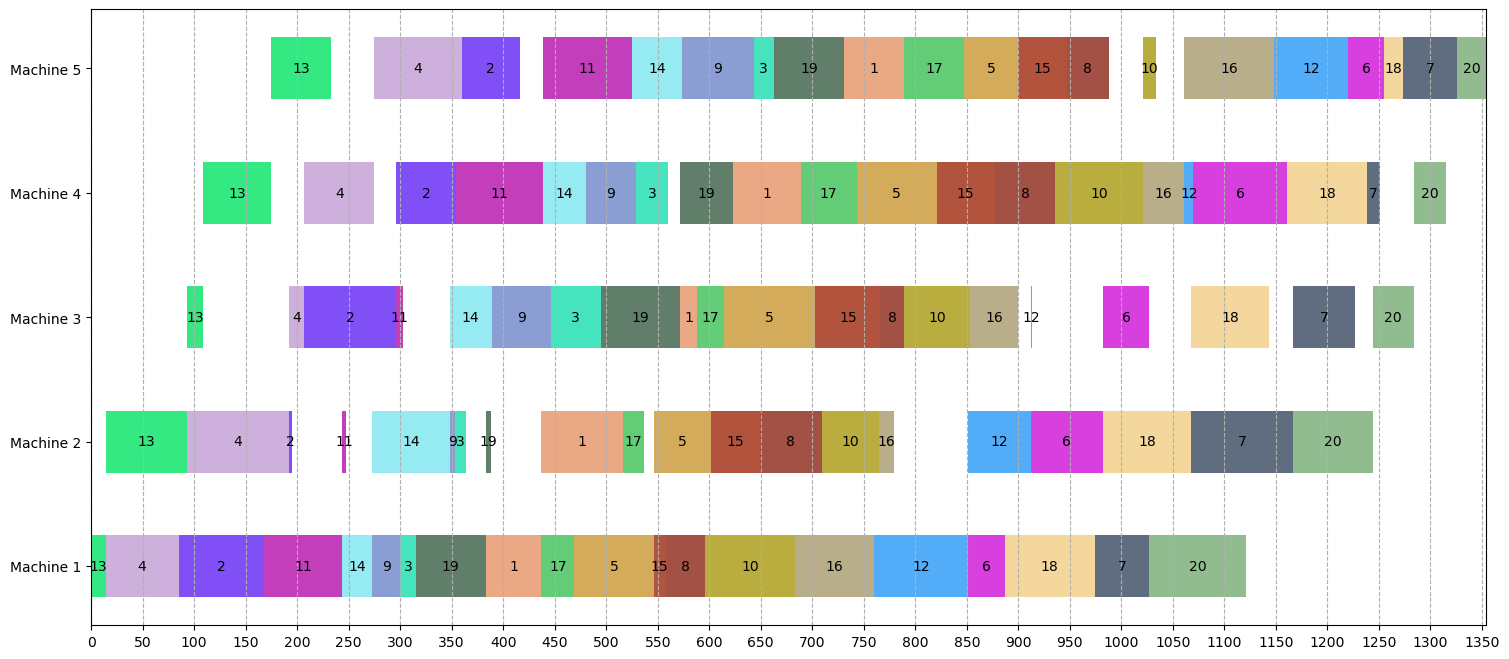

In [13]:
generate_gantt_chart(processing_times,best_solution)

### Meilleurs Hyper Parameters

In [129]:
# Définir l'espace des paramètres
space = [
    Real(0.5, 0.9, name='alpha'),
    Real(0.5, 0.9, name='beta'),
    Real(0.1, 0.9, name='Q'),
    Integer(10, 40, name='it_max'),
    Integer(10, 100, name='num_ant'),
    Real(0.1, 0.9, name='rho'),
]

# Fonction objectif à minimiser


@use_named_args(space)
def objective(**params):
    alpha = params['alpha']
    beta = params['beta']
    Q = params['Q']
    it_max = params['it_max']
    num_ant = params['num_ant']
    rho = params['rho']
   

    ACO = AntColonyOptimization(
    processing_times, Alpha=alpha, Beta=beta, Q=Q, max_it=it_max, num_ant=num_ant, rho=rho, heuristicSolution=initial_solution)
    
    result = ACO.run()
    
    return calculate_makespan(processing_times, result)


# Lancer l'optimisation
result = gp_minimize(objective, space, n_calls=20, random_state=0)
# Affichage des meilleurs paramètres trouvés

best_alpha = result.x[0]
best_beta  = result.x[1]
best_Q = result.x[2]
best_it_max = result.x[3]
best_num_ant = result.x[4]
best_rho = result.x[5]


Elapsed time: 6.0433104038238525 seconds
Elapsed time: 4.947545289993286 seconds
Elapsed time: 3.1355223655700684 seconds
Elapsed time: 4.7651684284210205 seconds
Elapsed time: 1.6329498291015625 seconds
Elapsed time: 1.3429248332977295 seconds
Elapsed time: 3.740278482437134 seconds
Elapsed time: 1.5499176979064941 seconds
Elapsed time: 6.866034269332886 seconds
Elapsed time: 2.8997137546539307 seconds
Elapsed time: 6.509196758270264 seconds
Elapsed time: 1.8869082927703857 seconds
Elapsed time: 3.616468667984009 seconds
Elapsed time: 3.43629789352417 seconds
Elapsed time: 3.6149063110351562 seconds
Elapsed time: 0.399869441986084 seconds
Elapsed time: 3.6353635787963867 seconds
Elapsed time: 3.9626846313476562 seconds
Elapsed time: 1.0458362102508545 seconds
Elapsed time: 4.113761901855469 seconds


In [130]:
processing_times = benchmarks[0][2].T

initial_solution =  [np.random.permutation(processing_times.shape[0]).tolist() for i in range(pop_size)]

print("Initial solution : ", initial_solution)

best_solution, best_solution_cost, elapsed_time = genetic_algorithm(processing_times, initial_solution, pop_size, select_pop_size, selection_method, crossover, mutation_probability, num_iterations)

print("Solution : ", best_solution)
print("Makespann " , best_solution_cost)
print("Elapsed time:", elapsed_time, "seconds")   

Elapsed time: 3.692780017852783 seconds
Solution :  [4, 3, 2, 12, 19, 16, 14, 7, 8, 13, 15, 5, 18, 0, 1, 6, 17, 11, 10, 9]
Makespann  1367


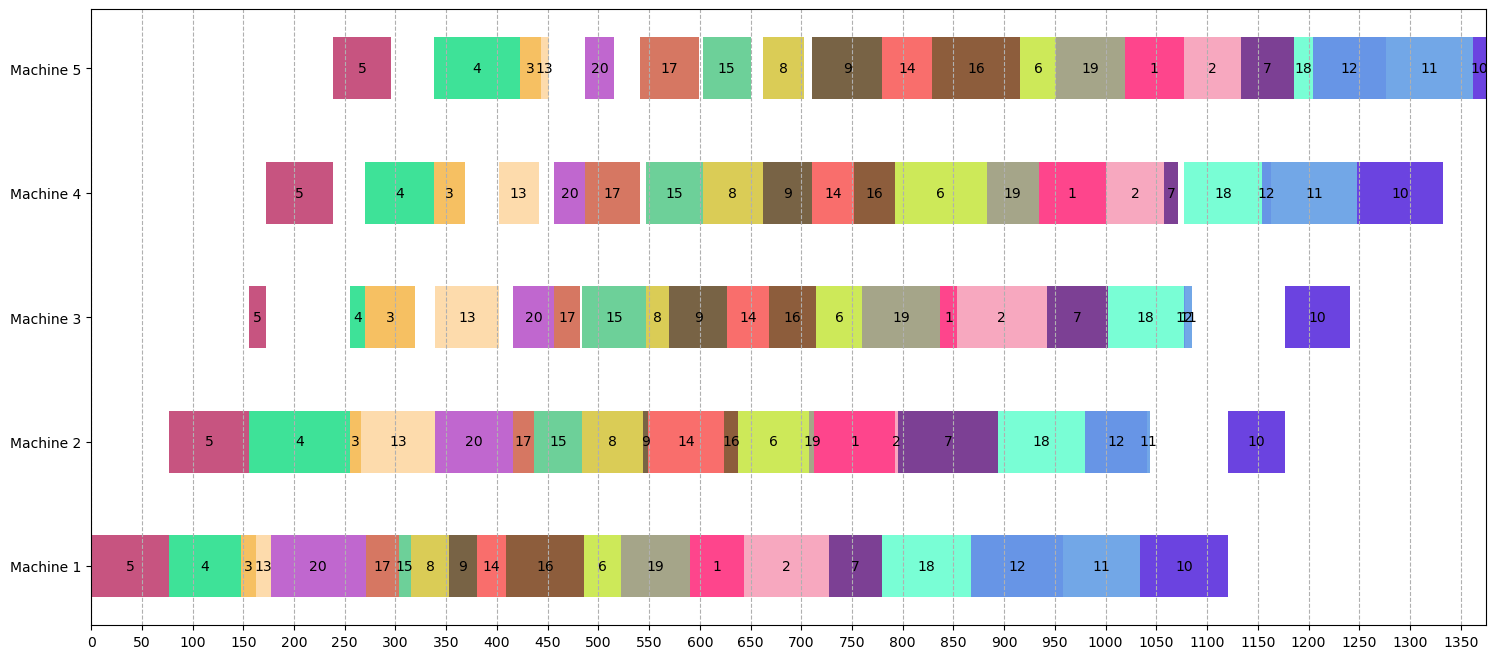

In [131]:
generate_gantt_chart(processing_times,best_solution)

##  Taillard, 50 jobs & 10 machines

In [39]:
nb_jobs = 50
nb_machines = 10
benchmarks = read_flow_shop_data(f'./utils/benchmarks/{nb_jobs}_{nb_machines}.txt', nb_machines, nb_jobs)

In [40]:
pop_size = 30
select_pop_size = 0.5
selection_method = "roulette"
crossover = "TWO"
mutation_probability = 0.05
num_iterations = 100

In [53]:
processing_times = benchmarks[0][2].T

initial_solution =  [np.random.permutation(processing_times.shape[0]).tolist() for i in range(pop_size)]

print("Initial solution : ", initial_solution)

best_solution, best_solution_cost, elapsed_time = genetic_algorithm(processing_times, initial_solution, pop_size, select_pop_size, selection_method, crossover, mutation_probability, num_iterations)

print("Solution : ", best_solution)
print("Makespann " , best_solution_cost)
print("Elapsed time:", elapsed_time, "seconds")     

Initial solution :  [[0, 19, 7, 3, 16, 18, 4, 10, 9, 14, 6, 15, 5, 13, 12, 11, 1, 8, 17, 2], [14, 2, 13, 9, 7, 5, 1, 17, 3, 6, 10, 15, 18, 19, 12, 16, 11, 8, 0, 4], [19, 13, 4, 0, 3, 5, 18, 2, 1, 9, 14, 11, 17, 10, 7, 12, 8, 16, 15, 6], [16, 13, 18, 17, 2, 3, 8, 7, 5, 1, 0, 11, 4, 15, 12, 19, 9, 10, 6, 14], [0, 11, 13, 14, 12, 16, 8, 19, 5, 3, 10, 6, 18, 1, 17, 15, 4, 7, 2, 9], [9, 19, 2, 13, 17, 7, 0, 10, 15, 18, 12, 16, 5, 4, 8, 6, 1, 3, 11, 14], [16, 12, 1, 7, 0, 10, 15, 8, 13, 6, 5, 18, 9, 2, 4, 19, 17, 11, 3, 14], [17, 9, 15, 12, 10, 6, 13, 16, 18, 8, 19, 2, 3, 14, 4, 7, 5, 11, 0, 1], [7, 0, 14, 5, 10, 19, 8, 12, 17, 15, 9, 11, 2, 18, 13, 3, 16, 1, 6, 4], [18, 5, 10, 1, 7, 2, 0, 14, 17, 3, 19, 12, 11, 4, 6, 13, 8, 9, 16, 15], [7, 4, 13, 10, 9, 11, 18, 19, 0, 14, 16, 3, 17, 8, 15, 12, 2, 1, 5, 6], [13, 10, 12, 14, 15, 8, 16, 4, 0, 7, 2, 19, 18, 9, 6, 1, 17, 11, 3, 5], [16, 12, 4, 0, 17, 9, 18, 14, 3, 10, 7, 11, 1, 2, 6, 15, 19, 13, 8, 5], [0, 9, 18, 14, 10, 5, 1, 4, 13, 15, 3, 7, 1

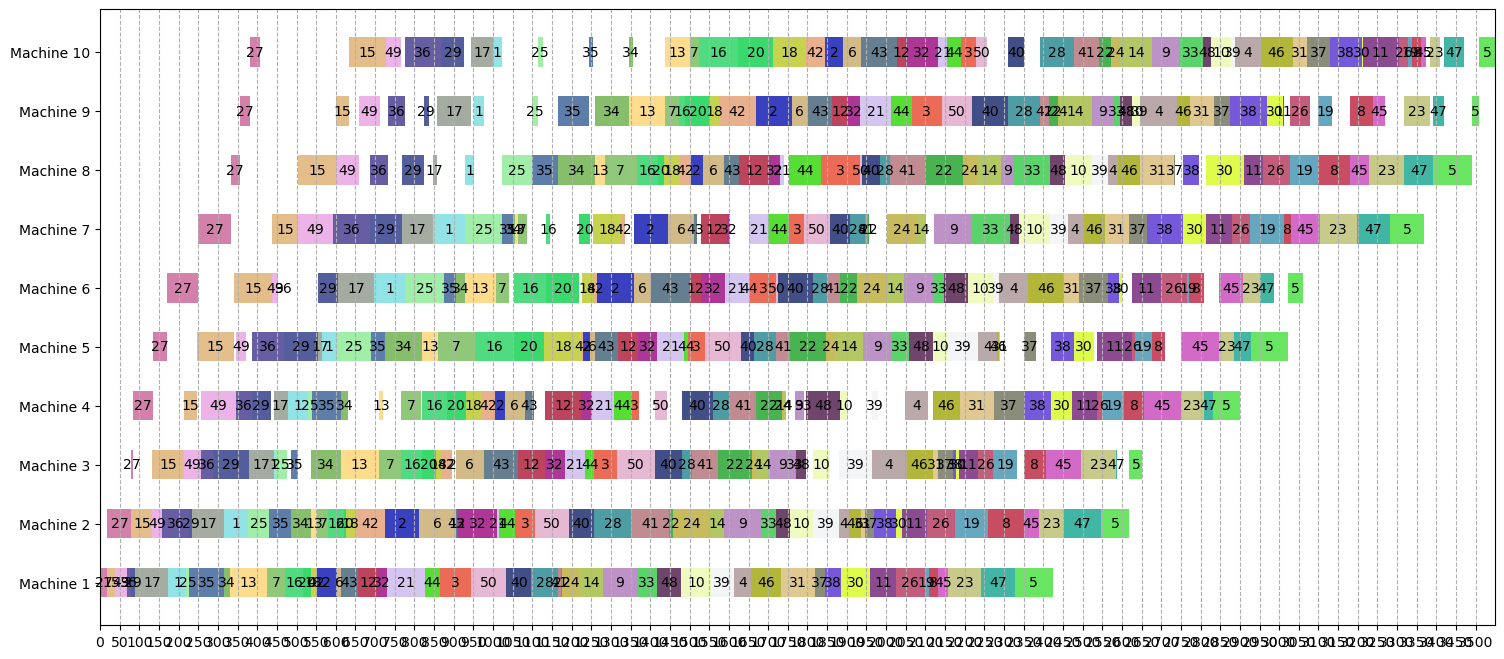

In [42]:
generate_gantt_chart(processing_times,best_solution)

##  Taillard, 100 jobs & 10 machines

In [44]:
nb_jobs = 100
nb_machines = 10
benchmarks = read_flow_shop_data(f'./utils/benchmarks/{nb_jobs}_{nb_machines}.txt', nb_machines, nb_jobs)

In [45]:
pop_size = 30
select_pop_size = 0.5
selection_method = "roulette"
crossover = "TWO"
mutation_probability = 0.05
num_iterations = 100

In [46]:
processing_times = benchmarks[0][2].T

initial_solution =  [np.random.permutation(processing_times.shape[0]).tolist() for i in range(pop_size)]

print("Initial solution : ", initial_solution)

best_solution, best_solution_cost, elapsed_time = genetic_algorithm(processing_times, initial_solution, pop_size, select_pop_size, selection_method, crossover, mutation_probability, num_iterations)

print("Solution : ", best_solution)
print("Makespann " , best_solution_cost)
print("Elapsed time:", elapsed_time, "seconds")    

Initial solution :  [[82, 202, 359, 175, 325, 95, 340, 159, 460, 477, 473, 465, 439, 90, 269, 33, 287, 92, 499, 417, 139, 83, 394, 388, 390, 312, 217, 132, 105, 172, 24, 428, 166, 364, 327, 245, 35, 302, 470, 158, 294, 256, 481, 437, 300, 183, 17, 197, 6, 162, 480, 368, 263, 160, 314, 419, 191, 149, 148, 75, 413, 140, 251, 103, 122, 396, 399, 427, 74, 190, 68, 279, 336, 489, 177, 49, 180, 355, 440, 236, 221, 186, 64, 59, 372, 297, 498, 3, 392, 277, 128, 146, 268, 367, 150, 211, 145, 313, 244, 169, 333, 445, 384, 220, 254, 418, 137, 329, 173, 326, 19, 291, 397, 330, 381, 196, 310, 387, 152, 53, 70, 436, 444, 206, 39, 205, 332, 296, 111, 71, 299, 476, 351, 285, 43, 455, 249, 342, 27, 382, 18, 124, 234, 435, 165, 385, 362, 174, 255, 472, 305, 281, 483, 8, 130, 488, 85, 240, 487, 228, 55, 199, 69, 46, 457, 120, 9, 288, 317, 119, 207, 348, 405, 315, 431, 386, 371, 58, 261, 479, 133, 135, 276, 219, 63, 144, 88, 143, 301, 113, 115, 23, 462, 272, 363, 22, 404, 482, 406, 486, 37, 156, 218, 409,

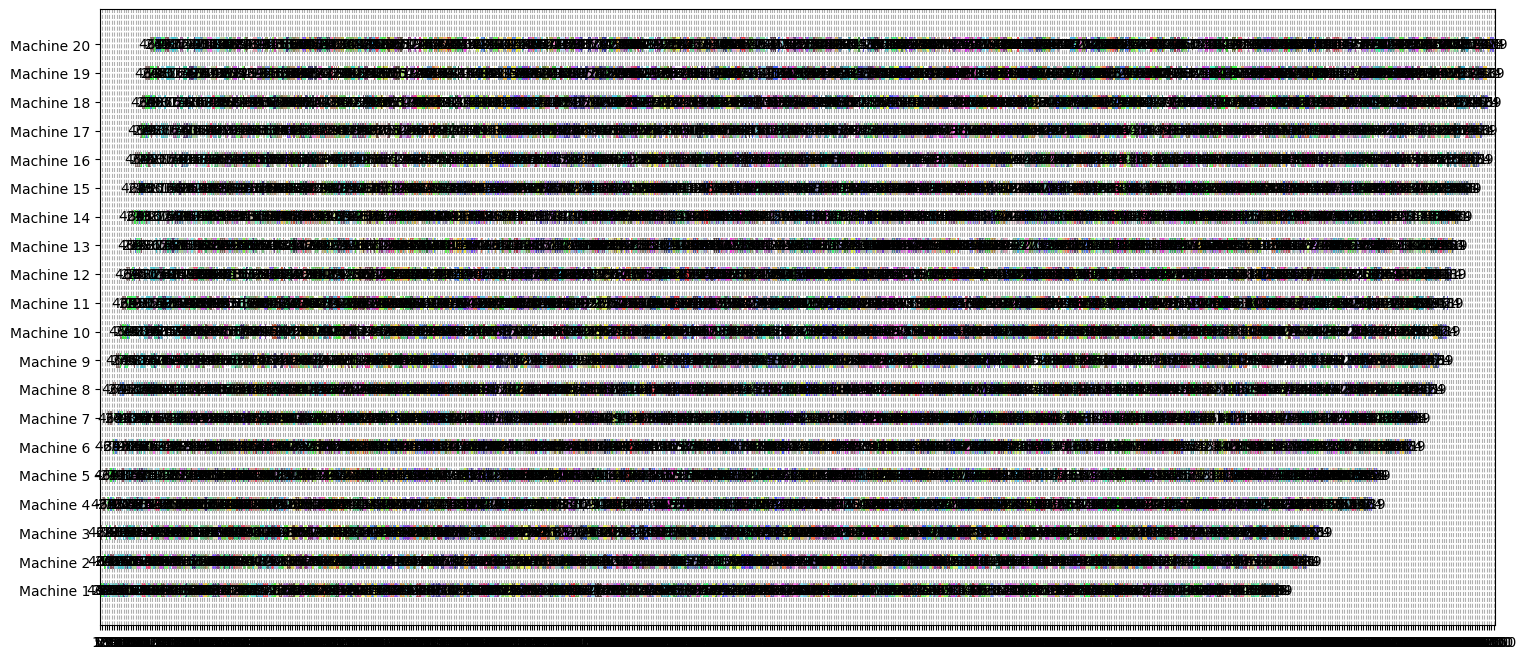

In [47]:
generate_gantt_chart(processing_times,best_solution)